Group name:[7] OceanWarlocks

Group number:7 

Skage Klingstedt Reistad, studentnr : 545212

Susan Desirée Bredesen Palencia, studentnr : 529305

In [ ]:
from datetime import datetime
import pandas as pd

## Exploratory data analysis

#### Domain Knowledge

After reading the dataset definitions and explainations, we started to search after relevant papers about vessel trajectory prediction (VTP). Our relevant findings can be divided into two parts: significant input features and state-of-the art ML methods. 

According to research some of the most important and most widely used input features for VTP (in addition to timestamps, latitude and altitude) are SOG, COG, heading, ship type and information about ports (Yang et al, 2024, p. 7).  

The same paper also mentioned that some of the most used approaches to VTP are LSTM networks and its variants, especially bidirectional variants (Yang et al, 2024, p. 7). This is mostly because VTP can be approached as a time series problem because the data always contain a temporal dimension (Yang et al, 2024, p. 7).

We used these findings as a basis and inspiration for our feature engineering, and to develop our first but (not accurate!) predictor. 



#### Checking if data is intuitive
We mostly used the AIS data, and therefore checked if especially the AIS data made sense to us. We checked for duplicated rows and missing values. We found that ETA was not in a datetime format and did not include years, we wanted it to be a datetime object and that was something we fixed during data clean up and by fixing the year to be 2024. This is not an unknown problem, because ETA is often manually entered and therefore is often in inconsistent data formats (Yang et al, 2024, p. 4).

We found that the other features were of suitable data types. Note that portID and vesselID are strings, when we did feature engineering we tried adding portID and vesselID as features and we converted them to integers as can be seen in the "cleaning features" section.

We found no duplicated rows, but we found that portID had 1615 missing values. We did let portID have its missing values, as we thought there we no particular negative consequence to have data rows with missing portIDs. Especially because that when we use portID we change them to integers, and that makes the missing portIDs into zeroes (which most predictors easily can handle).

We also used some vesselData, and found that it included a lot of missing values (as seen below). We only tried to add vesselType as a feature, and we fixed the missing values by making into a categorical and letting missing values be its own category. 

In [1]:
RESOURCE_FOLDER="../../resources"
import pandas as pd

In [ ]:

df_ais = pd.read_csv(RESOURCE_FOLDER+'/ais_train.csv', sep='|')

df_ais['time'] = pd.to_datetime(df_ais['time'])

print("Shape of AIS: " + str(df_ais.shape))
#n = 1522065
#columns = 11
print("Columns of AIS: "+ str(df_ais.columns))
#latitude and longitude are our targets. Relevant covariates may be time, cog, sog, rot, heading, navstat, etaRAW, vesselId and portId.

print("Data types of each of the columns") 
print(df_ais.dtypes)
#time is a datetime object.
# cog, latitude and longitude are floats. Rot, heading and navstat are ints. etaRaw, vesselId and portId are objects. 

print("Describtion of AIS data")
print(df_ais.describe())
#cog: course over ground. From 0 to 360 degrees.
#sog: speed over ground. from 0 to 1023 knots. 
#rot: rate of turning (of heading, which is the compass direction of where the boats bow/nose is heading). Degrees per minute.
#heading: direction of where boats bow is pointing. Measured in degrees from 0 to 360.
#navstat: Navigational status. The number tells the status of the boat. From 0 to 15.
#latitude: north-south position. Degrees. From -90 (south) to +90 (north). 
#longitude: east-west position. Degrees. From -180 (west) to +180 (east)

print("Checking where I have missing values")
print(df_ais.isna().sum()) #portId (1615 entries)

print("Checking for duplicated rows")
df_ais.loc[df_ais.duplicated()] #No duplicated rows

Shape of AIS: (1522065, 11)
Columns of AIS: Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId'],
      dtype='object')
Data types of each of the columns
time         datetime64[ns]
cog                 float64
sog                 float64
rot                   int64
heading               int64
navstat               int64
etaRaw               object
latitude            float64
longitude           float64
vesselId             object
portId               object
dtype: object
Describtion of AIS data
                                time           cog           sog  \
count                        1522065  1.522065e+06  1.522065e+06   
mean   2024-03-06 03:20:23.657231360  1.782494e+02  6.331703e+00   
min              2024-01-01 00:00:25  0.000000e+00  0.000000e+00   
25%              2024-02-03 02:59:19  7.820000e+01  0.000000e+00   
50%              2024-03-07 12:34:57  1.838000e+02  5.000000e-01   
75%              2024-0

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId


In [10]:
df_vessels = pd.read_csv(RESOURCE_FOLDER+'/vessels.csv', sep='|')

print("Data types of each of the columns") 
print(df_vessels.dtypes)

print("Checking where I have missing values")
print(df_vessels.isna().sum()) 
print("Checking for duplicated rows")
df_vessels.loc[df_vessels.duplicated()] #No duplicated rows

Data types of each of the columns
shippingLineId     object
vesselId           object
CEU                 int64
DWT               float64
GT                  int64
NT                float64
vesselType        float64
breadth           float64
depth             float64
draft             float64
enginePower       float64
freshWater        float64
fuel              float64
homePort           object
length            float64
maxHeight         float64
maxSpeed          float64
maxWidth          float64
rampCapacity      float64
yearBuilt           int64
dtype: object
Checking where I have missing values
shippingLineId      0
vesselId            0
CEU                 0
DWT                 8
GT                  0
NT                524
vesselType         12
breadth             8
depth             469
draft             701
enginePower        20
freshWater        490
fuel              490
homePort          138
length              0
maxHeight         676
maxSpeed          498
maxWidth          676

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt


#### Understanding how the data was generated

Note that we have irregular timestamps (as seen in the head of the AIS data). This is a known problem as AIS data has a lot of quality issues that leads to irregular timestamps. Two examples of this is that AIS messages has a tendency to get lost or damaged due to meterology and magnetics and that AIS tranceivers may also be intentionally turned off, which leads to missing data (Yang et al, 2024, p. 4).

Irregular timestamps was a big challenge during our whole project, and we believe we could have made a more accurate model if they were regularized. How we accounted for this issue will be followed in the predictors section.

In [8]:
print(df_ais.head(10))

                 time    cog   sog  rot  heading  navstat       etaRaw  \
0 2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1 2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2 2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3 2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4 2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   
5 2024-01-01 00:05:13  186.9   0.0    0      187        5  12-20 02:40   
6 2024-01-01 00:05:40  123.4   0.0  128      511        5  12-16 01:00   
7 2024-01-01 00:05:49  151.2   0.0    0       20        5  12-31 18:30   
8 2024-01-01 00:06:18  265.0   0.1    0      122        1  12-30 19:00   
9 2024-01-01 00:06:29   36.0   0.0    0       70        5  12-30 19:55   

   latitude  longitude                  vesselId                    portId  
0 -34.74370  -57.85130  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f  
1   8.89440  -79.47939  61e9f3d

#### Exploring individual features

We explored some individual features to find out if we could represent them in a clearer way for our models.

First we explored ROT, and we found out that ROT could perhaps be better represented as a catagorical described under. To check if this is a better representation (or that ROT is useful at all) we need to do feature engineering.

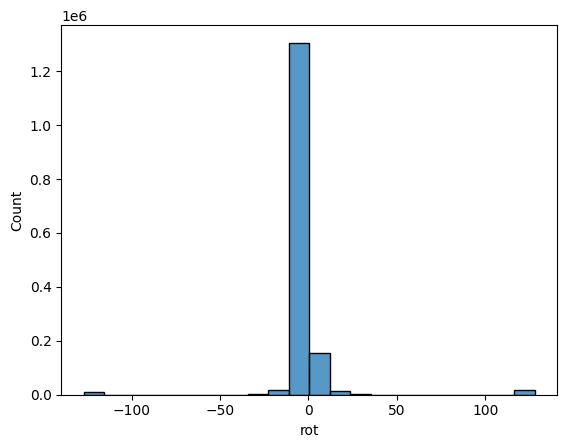

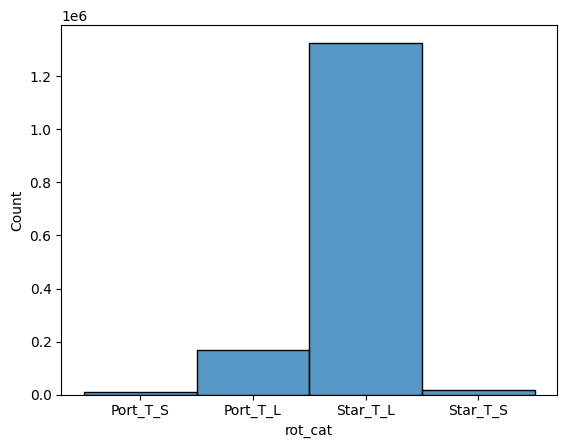

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.histplot(x = "rot", data = df_ais)
plt.title("Histogram of ROT-values")
plt.show()
#This show me that I have ROT-values that are quite small, most are between 0 and -40 (by eyesight). I want to make this into a categorical based on what I see.
#But be careful about the y-axis I have a big amount of values other than between 0 and -40.

#Want to make this into a categorical.
#I want my bins to be [-127, -126, 0, 126, np.inf]

toy_df = df_ais.copy()


bins = [-127, -126, 0, 127, np.inf] #Based on the interpretation of the ROT and the histogram.

labels = ["Port_T_S", "Port_T_L", "Star_T_L", "Star_T_S"]

toy_df["rot_cat"] = pd.cut(toy_df["rot"], bins = bins, labels = labels, right = False)

sns.histplot(x = "rot_cat", data = toy_df)
plt.title("Histogram of categorical ROT-values")
plt.show()

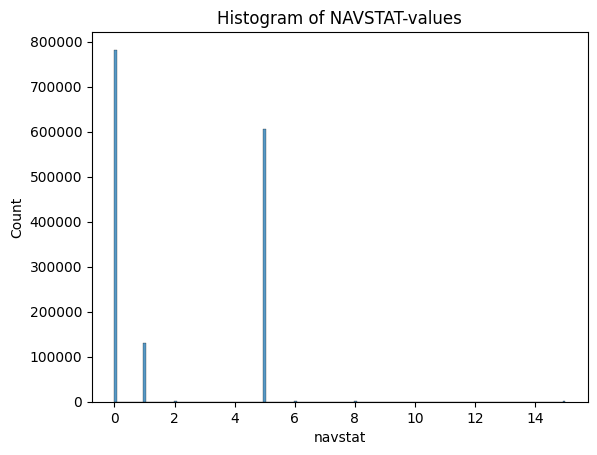

navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
12         1
13         1
14         1
7          1
9          1
Name: count, dtype: int64


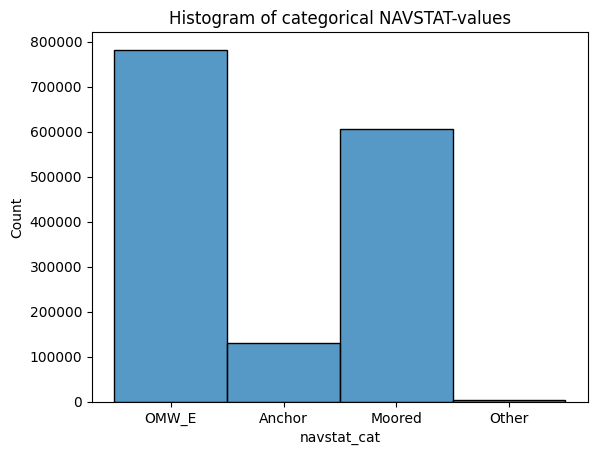

         navstat navstat_cat
0              0      moving
1              1  not_moving
2              0      moving
3              1  not_moving
4              0      moving
...          ...         ...
1522060        0      moving
1522061        0      moving
1522062        0      moving
1522063        0      moving
1522064        0      moving

[1522065 rows x 2 columns]
time           datetime64[ns]
cog                   float64
sog                   float64
rot                     int64
heading                 int64
navstat                 int64
etaRaw                 object
latitude              float64
longitude             float64
vesselId               object
portId                 object
navstat_cat            object
dtype: object


In [ ]:
#Looking at NAVSTAT
toy_data = df_ais.copy()

sns.histplot(x = "navstat", data = df_ais)
plt.title("Histogram of NAVSTAT-values")
plt.show()


print(toy_data["navstat"].value_counts())
#Which means that I want navstat to be a categorical, with 0, 1 and 5 and everything else.
# Where 0 means under way using engine, 1 means at anchor and 5 means moored. 


important_values = {0: "OMW_E", 1: "Anchor", 5: "Moored"}

# Create a new column with categories
toy_data['navstat_cat'] = toy_data['navstat'].apply(lambda x: important_values.get(x, "Other"))

sns.histplot(x = "navstat_cat", data = toy_data)
plt.title("Histogram of categorical NAVSTAT-values")
plt.show()

         navstat navstat_cat
0              0      moving
1              1  not_moving
2              0      moving
3              1  not_moving
4              0      moving
...          ...         ...
1522060        0      moving
1522061        0      moving
1522062        0      moving
1522063        0      moving
1522064        0      moving

[1522065 rows x 2 columns]
time           datetime64[ns]
cog                   float64
sog                   float64
rot                     int64
heading                 int64
navstat                 int64
etaRaw                 object
latitude              float64
longitude             float64
vesselId               object
portId                 object
navstat_cat            object
dtype: object


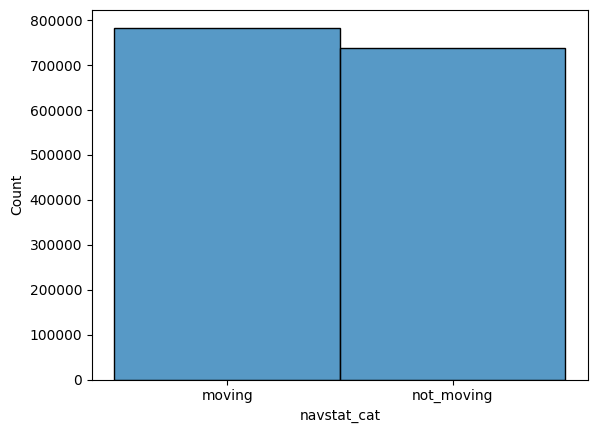

In [ ]:
#Wondering if it would be better to have a moving/not moving category instead of the one above.

#Letting 0, 3, 4 and 8 be moving and the rest not moving.

#This is based on the description of the navstat values in the data description.

movement_values = [0, 3, 4, 8]

toy_data["navstat_cat"] = np.where(toy_data["navstat"].isin(movement_values), "moving","not_moving")

print(toy_data[["navstat", "navstat_cat"]])

print(toy_data.dtypes)

sns.histplot(x = "navstat_cat", data = toy_data)
plt.show()

#### Cleaning up features

XGBoost doesn't accept input in any other form than floats, integers or booleans. For this reason date strings were turned into datetime objects and were eventually turned into time-difference in days or seconds. This became an especially pressing issue as we noticed that the eta did not feature years. We assumed that every year involved in this data was the year of 2024 since the dataset ends in the summer of 2024, and it no longers takes any ship more than half a year to reach any part of the globe.

Strings were either categorized into integers or represented as dummies. This was especially relevant when we tried to make a LSTM model with Tensorflow as Tensorflow doesn't take anything else than floats.

We used the csvs ais_train.csv and ports.csv. After extensive search for relevant features, we ended up using the following features: time, cog, sog, rot, heading, navstat, eta, latitude, longitude, vesselId, portLongitude, portLatitude, portId and navstat.

time, vesselId and portId aren't included as features in the final dataset fed to the model, but rather as sorting parameters for feature engineering, for sorting the dataset and creating target features. For instance, days_to_eta is found by subtracting the time from the eta-date.

In [ ]:


def parse_time(raw_time):
        try:
            date_format = "%m-%d %H:%M"
            parsed_datetime = datetime.strptime(raw_time, date_format)
            return parsed_datetime.replace(year = 2024)
        except ValueError:
            return None
        
example_eta_dataset = pd.DataFrame({"etaRaw": ["06-20 07:47", "06-20 13:47", "06-20 19:47", "06-21 01:47", "06-21 07:47"]})

example_eta_dataset["etaParsed"] = example_eta_dataset["etaRaw"].apply(parse_time)

print(example_eta_dataset)

        etaRaw           etaParsed
0  06-20 07:47 2024-06-20 07:47:00
1  06-20 13:47 2024-06-20 13:47:00
2  06-20 19:47 2024-06-20 19:47:00
3  06-21 01:47 2024-06-21 01:47:00
4  06-21 07:47 2024-06-21 07:47:00


## Predictors

#### LSTM

Our LSTM model was made with Tensorflow, and used on average data that went 8 hours into the past. This ended up failing though, as the Tensorflow model always predicted the same point on the face of the globe, regardless of parameters. We initially thought that this could be caused by features that weren't properly normalized, so we started writing normaliziation functions. However, the issue persissted and we had problems finding any satisfying solution. We ended up switching to XGBoost soon after.

#### XGBoost random forest
The random forest was an immediate improvement, that is, it tried to predict where the boat was going to be unlike our LSTM that just found the point on the earth that was closest to all the worlds boats.

Due to XGBoost being made up of tree models, we could use the features without having to normalize them, unlike in our LSTM model.

##### Regularized and supervised random forest

Our first XGBoost model used a resampling technique on 20 min intervals, and forwardfilling and filling in for lacking positions by using searouters predicted paths. Timesteps that were more than 20 min into the future were predicted by dividing up the future timesteps into 20 min intervals and predicting each next position in an iterative process. This model performed relativley poorly (Around 180-170 at best in kaggle score!), but miles better than the traditional LSTM model.

We also turned our time series problem into a supervised problem, since this was recommended in the time series lecture. Important paramteres were input window (how many shifts backwards in time) and output window (how many shifts forward in time). We tried different input windows (8,4,2,1), but let our output window be the same (1), and found that input window 4 gave the best Kaggle score.

We also used boosting rounds to fit our random forest, and found that 30 boosting rounds were our preferred amount since these boosting rounds used a lot of time for training. To hinder overfitting we used quite a low number for early stopping, around 3.

We also tuned our hyperparameters: {max_depth, colsample_bynode, num_parallel_tree and subsample}. We used randomsearch, to spare ourselves some time, and found two combinations of hyperparameteres that seemed promising. The two combinations were {7, 0.4, 50, 0.6} and {10, 0.4, 50, 0.4}. Our Kaggle results showed that it prereffered the first set of hyperparameters. The best Kaggle Score from this model was 171.


One of the major issues with this model is that the forward-filled rows were also used as target features in the training phase. This is why we eventually switched to an interval trained random forest model.


##### Interval trained random forest

Interval trained random forest was our final type of model. Our method merely took an earlier timestep, and found the difference in time between the feature rows time and the time of the position to predict. The catch in this model was that after we have divided the vessels travelpaths into 5 day intervals, we trained the model on features from the first timestep in that interval, and tried to predict the entire rest of the path.

We changed this function later so that we could also train on 1, 2 and 3 day intervals. We found that our best model was when we had 1, 3 and 5 days intervals, and that our next best model was when we had 1, 2, 3 and 5 days intervals.

We still used a boosted random forest. The training took a lot less time, so we tried to use more boosting_rounds (around 100) with early_stopping at 3. We actually found out that using so many boosting_rounds lead to a lower Kaggle result (by possibly overfitting to the training data), so we lowered it to 30 and got better Kaggle results.

We also tuned our hyperparameters: {max_depth, colsample_bynode, num_parallel_tree and subsample}. We used gridsearch, since training this model took a lot less time than training the supervised and resampled random forest. From gridsearch we found that {10,0.5,30,0.7} were the best hyperparameters, this also gave us a better Kaggle result. And we therefore used it in our best models, which had the following Kaggle scores: 151.78732 and 148.93198.



## Feature engineering


#### Feature Engineering on supervised and resampled XGBoost random forest

We tried to improve upon this model with two major added features. First of all was a matrix of 2x2 latitude longitude grid system that kept track of how likely a boat was to leave this area, and in which direction. We called this our "Markov Square Matrix". It worked poorly and gave us a worse Kaggle result. We therefore did not include it in our models.

We were very interested in checking out the relevancy of navstat and rot (since none of them were mentioned in our literature search), and while the model interpretation plots showed that both were relevant, we wanted to check if we could present these features in a clearer way for the model. 

We tried to make navstat and rot categorical, and implemented them one at a time. Making navstat categorical gave us a better Kaggle score, while making rot categorical did not. So therefore we chose to not include rot categorical in our best models.

We also tried to use another categorizing system for navstat, by dividing into two categories: in movement and not in movement. This gave us a worse Kaggle result than using our first categorical navstat, so we did not use this new categorizing system. 

How rot and navstat were made categorical is shown in "Exploring individual features" in the EDA-part.

#### Feature Engineering on 5-day interval trained XGBoost random forest

First and foremost we wanted to check if vesselType was relevant, and we made vesselType a categorical (as shown in "Exploring individual features"). We added vesselType and found that it gave us a worse Kaggle score. We did not expect this, since the literature said that vesselType should be a relevant feature (Yang et al, 2023, p. 7).

In our first model we also included timedifference in seconds, minutes, hours and days. But we thought this was kind of redundant, so we tried to only include timedifference in seconds. This gave us a better Kaggle result, so in the models after we only included timedifference in seconds.

We also tried to add ETA, by using days_to_ETA, but this did not lead to an improvement.

We found before that making ROT categorical does lead to better accuracy, but that making navstat categorical does lead to better Kaggle score. So we tried doing that here too, but that did not lead to a worse Kaggle result. So we let navstat be a numerical instead.

Our last idea was to include a numerized version of vesselID, as we have included numerized version of ISO and UN_LOCODE (basically portID). We got a worse Kaggle score by doing this, so we did not include vesselID in our final models.



## Our two best models and the best supervised model

#### The best model and model interpretation

Our best model was the 5-day interval trained XGBoost random forest with the following Kaggle score: 148.93198. 

We used the following features: time, cog, sog, rot, heading, navstat, latitude, longitude, portLongitude, portLatitude, days_to_ETA, vesselType, ISO, UN_LOCODE and timedifference in seconds. We used the hyperparameters {10,0.5,30,0.7} and 30 boosting rounds with early stopping at 3. 

The model interpretation showed that the most important features were days_to_ETA, latitude, longitude, ISO, UN_LOCODE and timedifference in seconds. This was interesting, since we had expected vesselType to be an important feature. 

#### The second best model and model interpretation

Our second best model was the 5-day interval trained XGBoost random forest with the following Kaggle score: 151.78732. 

We used the following features: time, cog, sog, rot, heading, navstat, latitude, longitude, portLongitude, portLatitude, days_to_ETA, vesselType, ISO, UN_LOCODE and timedifference in seconds. We used the hyperparameters {10,0.5,30,0.7} and 30 boosting rounds with early stopping at 3. 

The model interpretation showed that the most important features were days_to_ETA, latitude, longitude, ISO, UN_LOCODE and timedifference in seconds. This was interesting, since we had expected vesselType to be an important feature. 

#### The best supervised and resampled model and model interpretation

Our best supervised model was the resampled and supervised XGBoost random forest with the following Kaggle score: 171. 

This model used the features: time, cog, sog, rot, heading, navstat, latitude, longitude, portLongitude, portLatitude, vesselType, ISO, UN_LOCODE, timedifference in days and timedifference in seconds. This model used the hyperparameters {7, 0.4, 50, 0.6} and 30 boosting rounds with early stopping at 3. 

The model interpretation showed that the most important features were days_to_ETA, latitude, longitude, ISO, UN_LOCODE and timedifference in days. This was interesting, since we had expected vesselType to be an important feature.

mdefinatw1.png
mde11simpe.png
model7.png

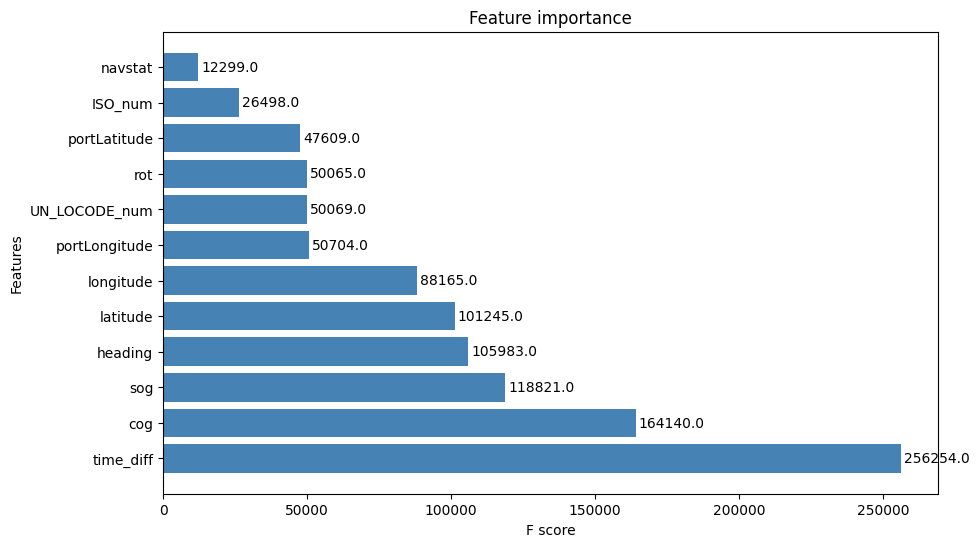

In [5]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Sample data for feature importances (you can replace it with your actual feature importances)
feature_importances = {
    'time_diff': 256254.0,
    'cog': 164140.0,
    'sog': 118821.0,
    'heading': 105983.0,
    'latitude': 101245.0,
    'longitude': 88165.0,
    'portLongitude': 50704.0,
    'UN_LOCODE_num': 50069.0,
    'rot': 50065.0,
    'portLatitude': 47609.0,
    'ISO_num': 26498.0,
    'navstat': 12299.0
}

# Extract features and their scores
features = list(feature_importances.keys())
scores = list(feature_importances.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, scores, color='steelblue')
plt.xlabel("F score")
plt.ylabel("Features")
plt.title("Feature importance")

# Display the values on the bars
for i, v in enumerate(scores):
    plt.text(v + 1000, i, str(v), va='center')

plt.show()

## Model Interpretation

#### Feature importance plots

## Sources

Yang, Y., Yang, L., Li, G., Zhang, Z. & Liu, Y.(2024).Harnessing the power of Machine learning for AIS Data-Driven maritime Research: A comprehensive review. Transportation Research Part E: Logistics and Transportation Review, 183, 103426. https://doi.org/10.1016/j.tre.2024.103426